Previously we talked about how we can use RL in a discrete domain. We talked about two different types of RL, that being value learning and Q learning. We also discussed how increasing the resolution of our domain or adding additional sensing leads to a massive increase in the number of values we need to learn. Since this leads to an increase in both training time and number of samples we need to collect, there has to be a better way to handle continuous domains, aka domains with a functionally infinitely small resolution.

Thankfully, there is and it is called actor critic! Rather than learning the value of a single state or a single state action pair, what if we learned a functional approximation of the state value? By that, I mean what if we could learn that V(s) = a*s1 + b*s2? That way, we wouldn’t have to have visited the point [0.562,0.621] before to know its value, we could simply plug that point into the equation to find its value. This is the basic idea of the critic portion of an actor critic. However, even if we know the value of a state we still have a problem. What action do we take next to improve our state value? One idea is to sample a number of points near the current state, feed them into our critic, and take the action that leads to the point with the highest value. This works for a simple domain, but fails under a few common circumstances. 

For one, as the state dimension increases, the number of points we need to sample increases exponentially. For a one dimensional system, we probably only need to sample 2 points. For a 2-d system, we might be able to get away with 72, essentially giving us a resolution of 5 degrees For a 3-d system, we could need over 2,500 points to get that same 5 degree resolution. 

For two, this assumes that we can fully map an action to the next state value, which could involve including a full kinematic solver into your agent. That takes significant amounts of time to solve and requires far more knowledge of the system than you may be given.

So, instead of sampling using the critic, what do we do? We train a second network that learns a functional mapping from the current state to the current action. Essentially, we want something that says if s1 < 0.5 and s2 > 0.3: a = 4 else a = -4. This network is the actor portion of our actor critic. But how do we know that this network will give us the right performance? Well, every time we take an action, we grade our actor’s performance using the critic. This way, as the critic learns which states are more or less valuable, it passes that information to the actor and it learns which actions lead to a better next state.

Lets run through an example. The code below establishes our environment. In this case, we are going to do the same 2d move to goal example that we did previously. This time, our position in x and y is represented by two decimals between 0 and 4 and we can move in both x and y simultaneously. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class Field():
    def __init__(self,h,w, start='rand', reward='dist', limited=False):
        self.height = h
        self.width = w
        self.turtle_pos = np.array([w/2,h/2])
        self.goal_pos = np.random.rand(2)
        self.turtle_orientation = 0
        self.start = start
        self.reward = reward
        self.limited = limited
        self.prev_vel = [0,0]
        
    def update_field_polar(self,action):
        if self.limited:
            self.turtle_orientation += action[1]/5
            if self.turtle_orientation > np.pi*2:
                self.turtle_orientation -= np.pi*2
            elif self.turtle_orientation < 0:
                self.turtle_orientation += np.pi*2
        else:
            self.turtle_orientation = action[1]*np.pi
        self.turtle_pos[1] += action[0] * np.sin(self.turtle_orientation)
        self.turtle_pos[0] += action[0] * np.cos(self.turtle_orientation)
        self.turtle_pos[0] = np.max([0,np.min([self.turtle_pos[0],self.width])])
        self.turtle_pos[1] = np.max([0,np.min([self.turtle_pos[1],self.height])])
        return self.calc_reward()

    def update_field_cartesian(self,action):
        if self.limited:
            temp_act = []
            temp_act.append(action[0]+self.prev_vel[0]/2)
            temp_act.append(action[1]+self.prev_vel[1]/2)
            self.turtle_pos[0] += temp_act[0] 
            self.turtle_pos[1] += temp_act[1]
            self.prev_vel = temp_act
        else:
            self.turtle_pos[0] += action[0] 
            self.turtle_pos[1] += action[1]
        self.turtle_pos[0] = np.max([0,np.min([self.turtle_pos[0],self.width])])
        self.turtle_pos[1] = np.max([0,np.min([self.turtle_pos[1],self.height])])
        return self.calc_reward()
        
    def calc_reward(self):
        dist = np.linalg.norm(self.turtle_pos-self.goal_pos)
        if self.reward == 'sparse':
            if dist < (self.height+self.width)/20:
                return 10
            else:
                return -0.3
        elif self.reward == 'dist':
            return -dist
        else:
            raise Exception('You need to set the reward type (sparse or dist)')
    
    def reset(self):
        self.turtle_pos = np.array([self.width/2,self.height/2])
        if self.start == 'rand':
            self.goal_pos = np.random.rand(2)
            self.goal_pos[0] = self.goal_pos[0] * self.width
            self.goal_pos[1] = self.goal_pos[1] * self.height
        elif self.start == 'trivial':
            self.goal_pos = np.array([0,0])
        elif self.start == 'easy':
            self.goal_pos = np.array([0.7,1])
        else:
            raise Exception('You need to set the start type (trivial, easy or rand)')

    
    def disp(self):
        plt.clf()
        plt.scatter(self.turtle_pos[0],self.turtle_pos[1])
        plt.scatter(self.goal_pos[0],self.goal_pos[1])
        plt.xlim(0,self.width)
        plt.ylim(0,self.height)
        plt.legend(['Robot', 'Goal'])
        plt.show()

Next, lets actually make the code that handles the actor and critic network. For now, we will just use a couple simple linear layers with relu activation functions. If you want to know more about that or the specific lower level machine learning concepts, take ROB 537 or ask your advisor if low level machine learning is right for you. Side effects may include hair loss, excessive caffeine use and loss of sleep. Here we are also initializing a replay buffer. This is essentially a way to store the state, action, next state and reward for a given timestep. This way, we can learn from a given action more than once by looking at it again when we better understand the value of the state space.

In [5]:
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import pi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def polar2cartesian(polar_tensor):
    cartesian_tensor = torch.zeros(polar_tensor.shape).to(device)
    if polar_tensor.shape[0] == 2:
        if len(polar_tensor.shape) == 1:
            r = polar_tensor[0]
            theta = polar_tensor[1]
            cartesian_tensor[0] = r*torch.cos(theta*pi)
            cartesian_tensor[1] = r*torch.sin(theta*pi)
        else:
            r = polar_tensor[0,:]
            theta = polar_tensor[1,:]
            cartesian_tensor[0,:] = r*torch.cos(theta*pi)
            cartesian_tensor[1,:] = r*torch.sin(theta*pi)
    elif polar_tensor.shape[1] == 2:
        r = polar_tensor[:,0]
        theta = polar_tensor[:,1]
        cartesian_tensor[:,0] = r*torch.cos(theta*pi)
        cartesian_tensor[:,1] = r*torch.sin(theta*pi)
    else:
        print('tensor of unexpected shape, returning unchanged')
    return cartesian_tensor

def cartesian2polar(cartesian_tensor):
    polar_tensor = torch.zeros(cartesian_tensor.shape).to(device)
    if cartesian_tensor.shape[0] == 2:
        if len(cartesian_tensor.shape) ==1:
            x = cartesian_tensor[0]
            y = cartesian_tensor[1]
            polar_tensor[0] = torch.sqrt(x**2+y**2)
            polar_tensor[1] = torch.atan2(y,x)/pi
        else:
            x = cartesian_tensor[0,:]
            y = cartesian_tensor[1,:]
            polar_tensor[0,:] = torch.sqrt(x**2+y**2)
            polar_tensor[1,:] = torch.atan2(y,x)/pi
    elif polar_tensor.shape[1] == 2:
        x = cartesian_tensor[:,0]
        y = cartesian_tensor[:,1]
        polar_tensor[:,0] = torch.sqrt(x**2+y**2)
        polar_tensor[:,1] = torch.atan2(y,x)/pi
    else:
        print('tensor of unexpected shape, returning unchanged')

    return polar_tensor


class critic(nn.Module):

    def __init__(self, input_shape, output_shape, encoder_type=None):
        super(critic, self).__init__()
        self.f1 = nn.Linear(input_shape, 10, dtype=torch.float)
        self.f1a = nn.Linear(10,10)
        self.f2 = nn.Linear(10, output_shape,dtype=torch.float)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # Called with either one element to determine next action, or a batch
    # during optimization. 
    def forward(self, x):
        
        x = x.to(self.device)
        x = F.relu(self.f1(x))
        x = F.relu(self.f1a(x))
        x = torch.tanh(self.f2(x)) * 5
        return x
    
class actor(nn.Module):

    def __init__(self, input_shape, output_shape, encoder_type=None):
        super(actor, self).__init__()
        self.f1 = nn.Linear(input_shape, 10, dtype=torch.float)
        self.f1a = nn.Linear(10,10)
        self.f2 = nn.Linear(10, output_shape,dtype=torch.float)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_type = encoder_type
        
    # Called with either one element to determine next action, or a batch
    # during optimization. 
    def forward(self, x):
        x = x.to(self.device)
        x = F.relu(self.f1(x))
        x = F.relu(self.f1a(x))
        x = torch.tanh(self.f2(x))
        if self.encoder_type=='p2c':
            x = polar2cartesian(x)
        elif self.encoder_type=='c2p':
            x = cartesian2polar(x)
        return x
    
    

class ReplayMemory(object):
    Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(ReplayMemory.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Finally, lets combine the actor and the critic and add functions for running experiments and training our network. Notice that initially we will be adding some random noise to our actions so that we explore the space a little more than we would if we just followed our actor and critic.


In [6]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time
from IPython import display


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class TurtleHRL():
    def __init__(self,start='rand', reward='dist', control='cartesian', limited=False,encoder_type=None):
        
        self.BATCH_SIZE = 128
        self.GAMMA = 0.999
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 600
        self.TARGET_UPDATE = 10
        
        self.actor_net = actor(6,2,encoder_type).to(device)
        self.actor_net.float()
        self.actor_target = copy.deepcopy(self.actor_net)
        self.critic_net = critic(8,1).to(device)
        self.critic_net.eval()
        self.critic_target = copy.deepcopy(self.critic_net)
        self.old_net = copy.deepcopy(self.critic_net)
        self.actor_optimizer = optim.RMSprop(self.actor_net.parameters())
        self.critic_optimizer = optim.RMSprop(self.critic_net.parameters())
        self.tau = 0.0005

        self.memory = ReplayMemory(10000)
        
        self.start = start
        self.reward = reward
        self.control = control
        self.limited = limited
        
        self.steps_done = 0

        self.current_ang = 0
        self.current_pos = [0,0]

        self.aloss = np.zeros((10000,))
        self.closs = np.zeros((10000,))
        self.ep = 0
        
        self.rewards = []
        
        self.modified = False # True means we transform from cartesian to polar

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.actor_net(state.float())
        else:
            with torch.no_grad():
                rand_thing =  4*torch.tensor([[random.random()-0.5,random.random()-0.5]], device=device, dtype=torch.float)
                thing = (self.actor_net(state.float()) +rand_thing).clamp(-1,1)
                return thing        
        
    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = ReplayMemory.Transition(*zip(*transitions))
    
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        next_states = [s for s in batch.next_state if s is not None]
        next_states = torch.stack(next_states)
        states = [s for s in batch.state if s is not None]
        states = torch.stack(states)
        next_actions = [self.actor_target(s) for s in next_states]
        alt_actions = [self.actor_net(s) for s in states]
        actions = [s for s in batch.action if s is not None]
        non_final_next_states_with_action = [torch.cat((next_states[i].to(device),next_actions[i])) for i in range(len(next_states))]
        non_final_next_states_with_action = torch.stack(non_final_next_states_with_action)
        state_and_action =  [torch.cat((states[i].to(device),actions[i].to(device))) for i in range(len(states))]
        state_and_action = torch.stack(state_and_action)
        alt_state_and_action =  [torch.cat((states[i].to(device),alt_actions[i].to(device))) for i in range(len(states))]
        alt_state_and_action = torch.stack(alt_state_and_action)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.cat(batch.reward).to(device)
        state_action_values = self.critic_net(state_and_action)
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)        
        next_state_values[non_final_mask] = self.critic_target(non_final_next_states_with_action).detach().reshape(self.BATCH_SIZE)
        expected_q_values = (next_state_values * self.GAMMA) + reward_batch.to(device)
        criterion = nn.MSELoss()
        critic_loss = criterion(state_action_values, expected_q_values.unsqueeze(1))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        for param in self.critic_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.critic_optimizer.step()
        actor_loss = -self.critic_net(alt_state_and_action).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        
        for param in self.actor_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.actor_optimizer.step()
        self.aloss[self.ep] = actor_loss.cpu().detach().numpy()
        self.closs[self.ep] = critic_loss.cpu().detach().numpy()
        self.ep +=1
        if self.ep % 10 == 9:
            for param, target_param in zip(self.critic_net.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for param, target_param in zip(self.actor_net.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        
    def collect_data(self,num_episodes,flag=False):
        field = Field(4,4, self.start, self.reward, self.limited)
        # you get 30 timesteps to get to the desired pose.
        for ep in range(num_episodes):
            field.reset()
            for i in range(30):
                state = list(field.turtle_pos) + [np.sin(field.turtle_orientation),np.cos(field.turtle_orientation)] + list(field.goal_pos)
                state = torch.from_numpy(np.array(state)).float()
                raw_action = self.select_action(state)
                raw_action = raw_action.to('cpu')
                if len(raw_action) == 1:
                    raw_action = raw_action[0]
                if self.control == 'cartesian':
                    done = field.update_field_cartesian(raw_action.numpy())
                elif self.control == 'polar':
                    done = field.update_field_polar(raw_action.numpy())
                else:
                    raise Exception('You need to set the control parameter (cartesian or polar)')
                next_state = list(field.turtle_pos) + [np.sin(field.turtle_orientation),np.cos(field.turtle_orientation)]  + list(field.goal_pos)
                next_state = torch.from_numpy(np.array(next_state)).float()
                if done > -0.2:
                    reward = 5
                    self.memory.push(state, raw_action, next_state ,torch.tensor([reward],dtype=torch.float))
                    break
                else:
                    reward = done
                    self.memory.push(state, raw_action, next_state ,torch.tensor([reward],dtype=torch.float))
                if flag:
                    print('state: ',state)
                    print('action: ',raw_action)
                    print('next state: ',next_state)
                    print('reward: ', reward)
            self.rewards.append(reward)
    
    def disp_episode(self,action=False):
        field = Field(4,4, self.start, self.reward, self.limited)
        # you get 30 timesteps to get to the desired pose.
        field.reset()
        for i in range(30):
            display.clear_output(wait=True)
            field.disp()
            time.sleep(0.5)
            state = list(field.turtle_pos) + [np.sin(field.turtle_orientation),np.cos(field.turtle_orientation)] + list(field.goal_pos)
            state = torch.from_numpy(np.array(state)).float()
            raw_action = self.select_action(state)
            raw_action = raw_action.to('cpu')
            if len(raw_action) == 1:
                raw_action = raw_action[0]
            if action:
                print('action: ', raw_action)
            if self.control == 'cartesian':
                done = field.update_field_cartesian(raw_action.numpy())
            elif self.control == 'polar':
                done = field.update_field_polar(raw_action.numpy())
            next_state = list(field.turtle_pos) + [np.sin(field.turtle_orientation),np.cos(field.turtle_orientation)]  + list(field.goal_pos)
            next_state = torch.from_numpy(np.array(next_state)).float()
            if done > -0.2:
                break
        display.clear_output(wait=True)
        field.disp()
        print('Finished Episode')
        
    def plot_reward(self):
        display.clear_output(wait=True)
        final_rewards = moving_average(self.rewards,10)
        plt.plot(range(len(final_rewards)),final_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (10 episodes)")
        plt.show()


Now that we have everything in place, lets run through a few examples. First, lets do the most basic example. The goal will always be in the bottom left corner of the map at 0,0. Furthermore, we consider any point that comes within 0.5 units of 0,0 to be successful. If you run the code below, that is what we will train.

epoch  199  finished
Percent of past 100 trials that were successful 100.0
average a loss for last 100 trials -0.13322064897045494
average c loss for last 100 trials 0.6762706427276135


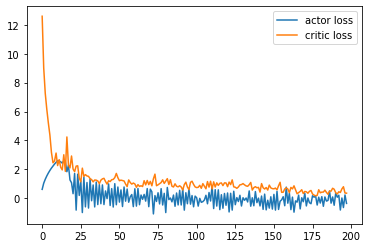

training took,  36.91  seconds


In [7]:
f = TurtleHRL('trivial','dist')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
reward_percents = []
epochs = []
for i in range(200):
    f.collect_data(1)
    f.optimize_model()
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

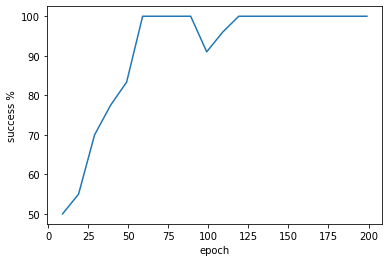

In [8]:
        plt.plot(epochs,reward_percents)
        plt.ylabel('success %')
        plt.xlabel('epoch')
        plt.show()

Now that we get a high percentage of successful trials, lets visualize the performance of the agent.

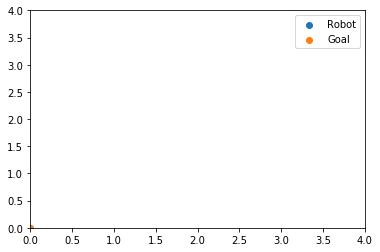

Finished Episode


In [9]:
f.disp_episode()

This works well (as it should). Why is this example so easy, and how can we make it harder?

Well first off, we can always move down and left and expect to succeed. It doesn’t matter if we go all the way down then left, or all the way left then down, we will get to the goal. How about we put the goal at 0.7,1 instead? This way, if we always move down and left we may miss the goal, especially if we hit the wall first. Lets run that now

epoch  999  finished
Percent of past 100 trials that were successful 30.0
average a loss for last 100 trials -0.10364514558110387
average c loss for last 100 trials 0.05832183634804096


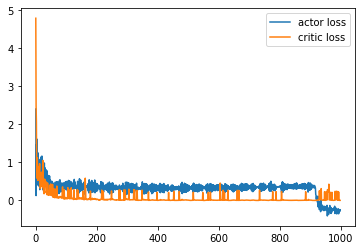

training took,  122.39  seconds


In [10]:
f = TurtleHRL('easy','dist')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(1000):
    f.collect_data(1)
    f.optimize_model()    
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

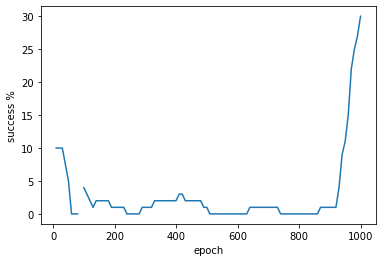

In [11]:
        plt.plot(epochs,reward_percents)
        plt.ylabel('success %')
        plt.xlabel('epoch')
        plt.show()

epoch  1999  finished
Percent of past 100 trials that were successful 1.0
average a loss for last 100 trials 0.9608037108182907
average c loss for last 100 trials 0.019665468189050444


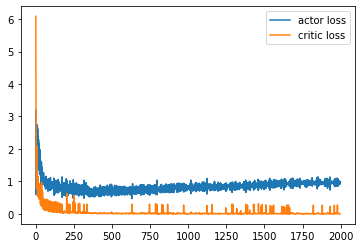

training took,  213.91  seconds


In [12]:
f = TurtleHRL('easy','dist','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

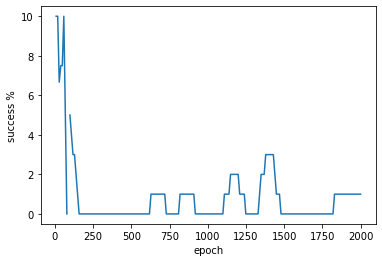

In [13]:
plt.plot(epochs,reward_percents)
plt.ylabel('success %')
plt.xlabel('epoch')
plt.show()

You should notice that this time it takes noticeably longer to train the agent. Keep in mind, this is still an easy task to complete, but it takes a while longer to get done. 

Lets visualize the agent now that it is fully trained.

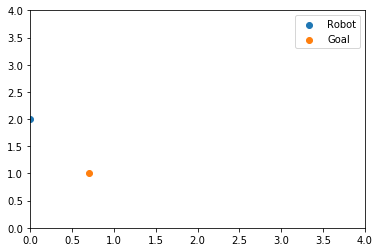

Finished Episode


In [14]:
f.disp_episode()

epoch  1999  finished
Percent of past 100 trials that were successful 99.0
average a loss for last 100 trials 0.9822838705778122
average c loss for last 100 trials 2.9876748192310334


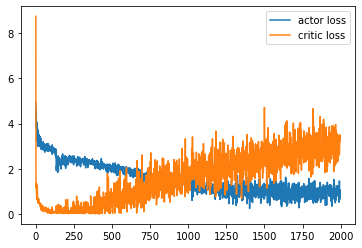

training took,  183.79  seconds


In [15]:
# Cartesian Limited

f = TurtleHRL('easy','dist','cartesian',True)
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

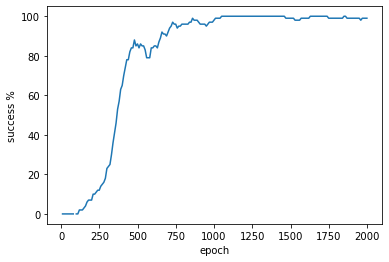

In [16]:
plt.plot(epochs,reward_percents)
plt.ylabel('success %')
plt.xlabel('epoch')
plt.show()

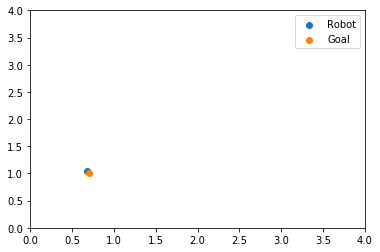

Finished Episode


In [17]:
f.disp_episode()

epoch  1999  finished
Percent of past 100 trials that were successful 60.0
average a loss for last 100 trials 2.146955519914627
average c loss for last 100 trials 0.4921536734700203


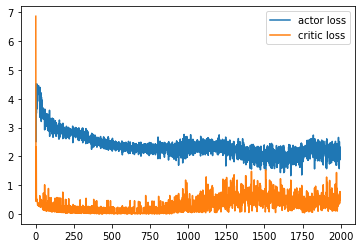

training took,  200.8  seconds


In [18]:
# Polar Limited

f = TurtleHRL('easy','dist','polar',True)
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

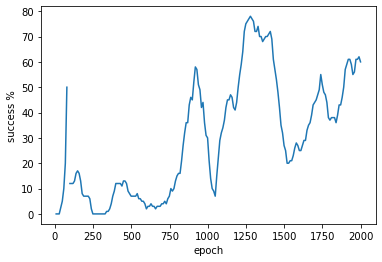

In [19]:
plt.plot(epochs,reward_percents)
plt.ylabel('success %')
plt.xlabel('epoch')
plt.show()

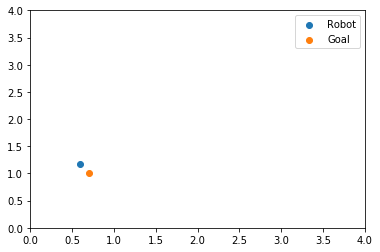

Finished Episode


In [20]:
f.disp_episode()

epoch  1999  finished
Percent of past 100 trials that were successful 8.0
average a loss for last 100 trials 0.8432705885171891
average c loss for last 100 trials 0.11303850529715419


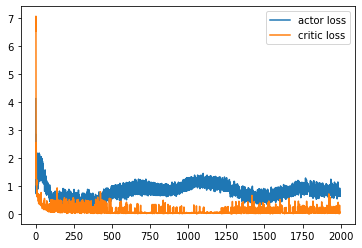

training took,  228.79  seconds


In [21]:
# in theory this should be a polar field, but our control implementation is in cartesian

f = TurtleHRL('easy','dist','polar',encoder_type='c2p')
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

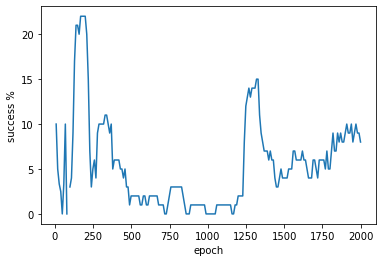

In [22]:
plt.plot(epochs,reward_percents)
plt.ylabel('success %')
plt.xlabel('epoch')
plt.show()

epoch  1999  finished
Percent of past 100 trials that were successful 100.0
average a loss for last 100 trials -0.35205567872151733
average c loss for last 100 trials 1.0841714870929717


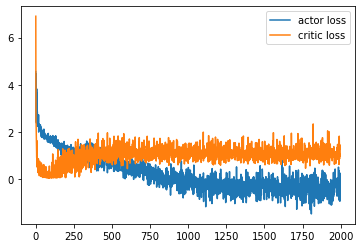

training took,  187.78  seconds


In [23]:
# in theory this should be a cartesian field, but our control implementation is in polar

f = TurtleHRL('easy','dist','cartesian',encoder_type='p2c')
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

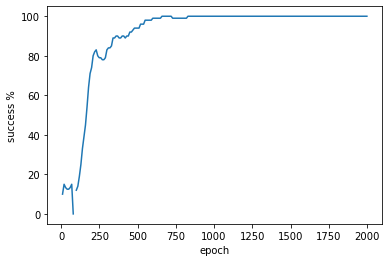

In [24]:
plt.plot(epochs,reward_percents)
plt.ylabel('success %')
plt.xlabel('epoch')
plt.show()

epoch  999  finished
Percent of past 100 trials that were successful 100.0
average a loss for last 100 trials -0.5500374062545598
average c loss for last 100 trials 1.1246832484006881


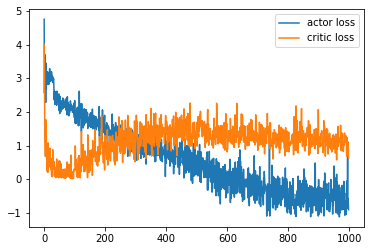

training took,  53.86  seconds


In [25]:
f = TurtleHRL('easy','dist')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(10)
reward_percents = []
epochs = []
start = time.time()
for i in range(1000):
    f.collect_data(1)
    f.optimize_model()    
    if i % 10 == 9:
        reward_percents.append(100*np.average(np.array(f.rewards[i-99:i+1])>0))
        epochs.append(i)
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

In [26]:
f.actor_net.encoder_type='c2p'
f.control = 'polar'
f.encoder_type='c2p'
f.collect_data(100)
print('Percent of 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))

Percent of 100 trials that were successful 100.0


epoch  2499  finished
Percent of past 100 trials that were successful 97.0
average a loss for last 100 trials 0.6543744358420372
average c loss for last 100 trials 2.0068750941753386


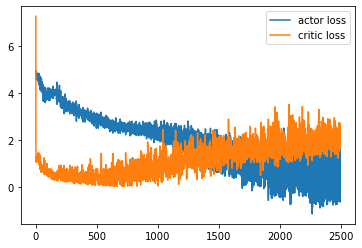

training took,  139.15  seconds


In [27]:
f = TurtleHRL('rand','dist')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(10)

start = time.time()
for i in range(2500):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

Notice that this time getting above 90% takes a long time. We still get there (or close, im not running the code, im just a script so I can't tell if you got unlucky) but it is much more time consuming and there were probably dips in performance from time to time.

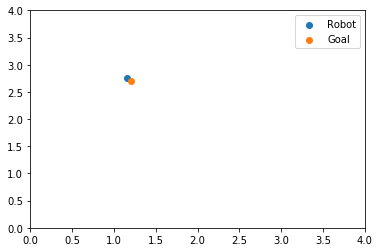

Finished Episode


In [28]:
f.disp_episode()

Now lets try making things even more interesting. This time we will take away our heuristic and try only giving the agent a positive reward if it gets to the goal. If not, it will get a reward of -0.3. This type of sparse reward function is common for tasks where we can't easily construct a heuristic. Again we will start with the trivial example in the bottom corner.

epoch  199  finished
Percent of past 100 trials that were successful 100.0
average a loss for last 100 trials -0.9948444122076034
average c loss for last 100 trials 0.36925305627286437


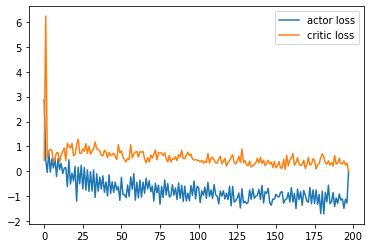

training took,  9.71  seconds


In [29]:
f = TurtleHRL('trivial','sparse')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(200):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

As expected, we still do well on this task. Its still a good idea to try the most basic example to make sure the problem is still solveable. Lets move on to the easy task.

epoch  999  finished
Percent of past 100 trials that were successful 100.0
average a loss for last 100 trials -2.8488546085357664
average c loss for last 100 trials 1.243236138820648


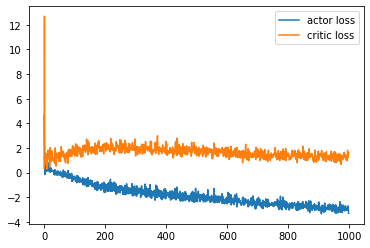

training took,  49.56  seconds


In [30]:
f = TurtleHRL('easy','sparse')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(1000):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

This task is also still learned. Maybe we didn't need to have the heuristic at all!

Try the random start position.

epoch  2499  finished
Percent of past 100 trials that were successful 15.0
average a loss for last 100 trials 1.775223286151886
average c loss for last 100 trials 0.1022161585954018


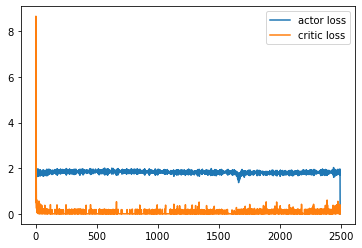

training took,  147.42  seconds


In [31]:
f = TurtleHRL('rand','sparse')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(2500):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

Even though we gave it 2500 epochs, it doesn't learn how to handle the problem. Why is that?

A good way to evaluate this is to look at the critic loss. It starts high, but then drops substantially, only interrupted by small momentary peaks. This is because the critic is assuming all actions are equally bad (or close to it). There are a very small number of successful trials in our dataset, and even for those, the only action with a positive reward is the last one. That means there is a lot of pressure for the network to assume an action will result in a reward of -0.3. As a result, it finds a local minima where it always gives -0.3 and just is wrong every once in a blue moon.

Interesting. Lets try a different control scheme. This time, rather than the action being the change in x and y, we instead make it the velocity in the direction it is facing and the change in angle. Lets try reinstating the heuristic and going through the difficulties.

epoch  199  finished
Percent of past 100 trials that were successful 85.0
average a loss for last 100 trials 0.7449820503592491
average c loss for last 100 trials 0.4811562405526638


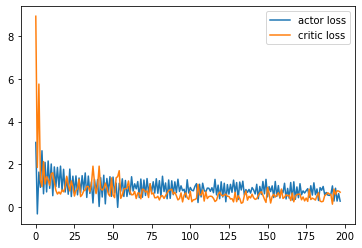

training took,  10.64  seconds


In [32]:
f = TurtleHRL('trivial','dist','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(200):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

As expected, the trivial problem is still doable. Lets vizualize it for fun though.

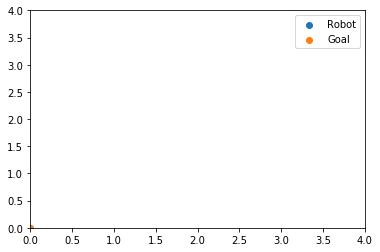

Finished Episode


In [33]:
f.disp_episode()

We take a bit of a less direct path this time because we can only rotate so quickly, but it is still finding the shortest route.

epoch  1999  finished
Percent of past 100 trials that were successful 6.0
average a loss for last 100 trials 2.3640120577812196
average c loss for last 100 trials 0.0854789852432441


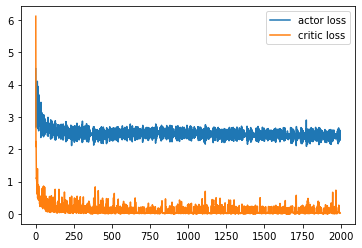

training took,  117.59  seconds


In [34]:
f = TurtleHRL('easy','dist','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

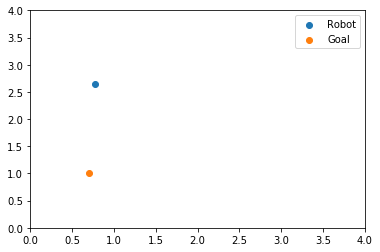

Finished Episode


In [35]:
f.disp_episode()

epoch  2499  finished
Percent of past 100 trials that were successful 94.0
average a loss for last 100 trials -0.6523055158555507
average c loss for last 100 trials 1.7465296220779418


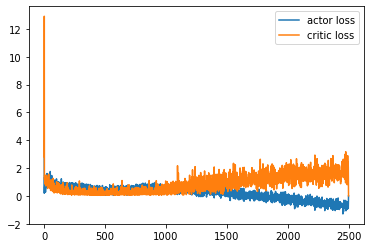

training took,  140.58  seconds


In [36]:
f = TurtleHRL('rand','dist','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(2500):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

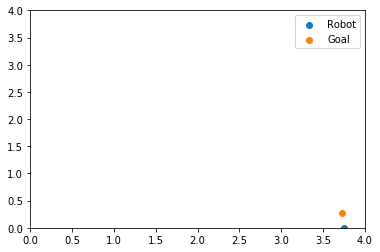

Finished Episode


In [37]:
f.disp_episode()

Lastly, run the polar coordinates with the sparse reward function

epoch  199  finished
Percent of past 100 trials that were successful 0.0
average a loss for last 100 trials 0.15874014047905802
average c loss for last 100 trials 0.03436108311871067


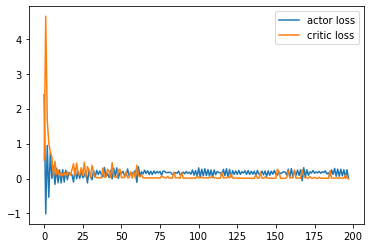

training took,  10.16  seconds


In [38]:
f = TurtleHRL('trivial','sparse','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(200):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

epoch  1999  finished
Percent of past 100 trials that were successful 85.0
average a loss for last 100 trials 0.7422274580597877
average c loss for last 100 trials 1.2093314856290818


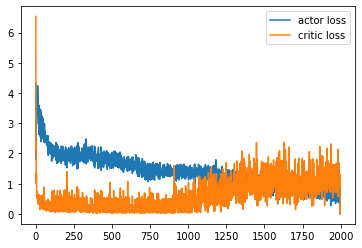

training took,  114.6  seconds


In [39]:
f = TurtleHRL('easy','dist','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(2000):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

epoch  2499  finished
Percent of past 100 trials that were successful 52.0
average a loss for last 100 trials 1.509658726453781
average c loss for last 100 trials 0.8096221867203712


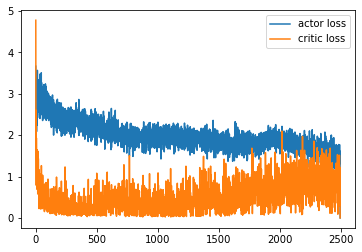

training took,  143.92  seconds


In [40]:
f = TurtleHRL('rand','dist','polar')
#collect some initial data so that the replay buffer has at least enough data to fill a batch
f.collect_data(2)

start = time.time()
for i in range(2500):
    f.collect_data(1)
    f.optimize_model()
    if i % 100 == 99:
        display.clear_output(wait=True)
        print('epoch ', i ,' finished')
        print('Percent of past 100 trials that were successful', 100*np.average(np.array(f.rewards[i-99:i+1])>0))
        print('average a loss for last 100 trials', np.average(f.aloss[i-99:i+1]))
        print('average c loss for last 100 trials', np.average(f.closs[i-99:i+1]))
        plt.plot(range(i-1),f.aloss[:i-1])
        plt.plot(range(i-1),f.closs[:i-1])
        plt.legend(['actor loss', 'critic loss'])
        plt.show()
end = time.time()
print('training took, ', round(end-start,2), ' seconds')

There are a few takaways from this exercise. 
1. If a task is easy enough, you can throw RL at it in the worst way possible and it will probably succeed. It won't be meaningful but it will work
2. If it is not trivial, you will need to be smart about your states, actions and rewards. It was easier for the algorithm to handle cartesian actions rather than polar because each action was independent of the other AND it lined up directly with the reward signal. Also, heuristics that accurately reflect the value of the state are incredibly useful.
3. Always try the easiest possible situation and work your way up. If we started with the random goal pose and no heuristic, we wouldn't know if our implementation of the algorithm was wrong or if the task was too complex.
4. Sparse rewards can work, but you need to have the right situation. You can't arbitrarily throw RL at any problem that can't be easily measured by using sparse rewards. If you do use sparse rewards, there are many ways to make them more effective (such as expert replay, ranking transition importance, etc)

In [41]:
plt.show()